# **Introduction**

This document explores the use of Sparse Autoencoders (SAEs) and SHAP (Shapley Additive Explanations) to interpret and understand feature activations in the GPT-2 small language model, particularly in the context of medical terms. SAEs, as key tools, are instrumental in identifying interpretable features within language models, thereby providing a clearer representation of the semantic patterns captured by the model. SHAP, on the other hand, is employed to evaluate the contribution of each feature to the model's output, offering a detailed understanding of the impact of different activated features in natural language processing.

This analysis is based on previous research in model interpretability, such as that conducted by Trenton Bricken et al. in "Towards Monosemanticity: Decomposing Language Models With Dictionary Learning," which demonstrates that SAEs can identify monosemantic and polysemantic features in language models. Tools and examples provided by the Saelens and TransformerLens libraries were also referenced, offering advanced methods for visualizing and analyzing neural features in language models. These resources enable the application of techniques like Activation Patching and SHAP, facilitating the identification of neural circuits within models and highlighting the ability of these methods to find complex relationships between text inputs and their corresponding model-generated responses.

Applying these methodologies provides a deeper understanding of how language models handle and process specific information, such as medical terms. It also offers new insights into how models can be fine-tuned or manipulated for specialized tasks, highlighting areas for improvement and future development in language model interpretability.



# **Methodology**

**Setup**

In [ ]:
!pip install sae-lens transformer-lens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.

In [ ]:
import numpy as np
import torch
import plotly_express as px

from transformer_lens import HookedTransformer

from sae_lens import SAE

from sae_lens.analysis.feature_statistics import get_W_U_W_dec_stats_df


## **Selection of Interesting SAE Features**


In [ ]:
model = HookedTransformer.from_pretrained("gpt2-small")

gpt2_small_sparse_autoencoders = {}
gpt2_small_sae_sparsities = {}

for layer in range(12):
    sae, original_cfg_dict, sparsity = SAE.from_pretrained(
        release="gpt2-small-res-jb",
        sae_id="blocks.0.hook_resid_pre",
        device="cpu",
    )
    gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"] = sae
    gpt2_small_sae_sparsities[f"blocks.{layer}.hook_resid_pre"] = sparsity

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


blocks.0.hook_resid_pre/cfg.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

In [ ]:
layer = 8

sparse_autoencoder = gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"]
log_feature_sparsity = gpt2_small_sae_sparsities[f"blocks.{layer}.hook_resid_pre"].cpu()

W_dec = sparse_autoencoder.W_dec.detach().cpu()

W_U_stats_df_dec, dec_projection_onto_W_U = get_W_U_W_dec_stats_df(
    W_dec, model, cosine_sim=True
)
W_U_stats_df_dec["sparsity"] = (
    log_feature_sparsity  # add feature sparsity since it is often interesting.
)


In [ ]:
px.histogram(
    W_U_stats_df_dec,
    x="skewness",
    width=800,
    height=300,
    nbins=1000,
    title="Skewness of the Logit Weight Distributions",
).show()

px.histogram(
    W_U_stats_df_dec,
    x=np.log10(W_U_stats_df_dec["kurtosis"]),
    width=800,
    height=300,
    nbins=1000,
    title="Kurtosis of the Logit Weight Distributions",
).show()

px.histogram(
    W_U_stats_df_dec,
    x=sparsity,
    width=800,
    height=300,
    nbins=1000,
    title="Sparsity of the Logit Weight Distributions",
).show()

The first graph shows that most logit weights have a skewness near 0, indicating approximately symmetric weight distributions. However, there is also a tail extending to the right, suggesting that some weights have positively skewed distributions with more high extreme values. The second graph, showing kurtosis, indicates that most logit weights have low kurtosis, implying lighter tails and fewer sharp peaks, but there are also weights with high kurtosis. This suggests that certain weight distributions have extreme values, which could indicate significant patterns in how the model weights outputs for specific features.

In [ ]:
fig = px.scatter(
    W_U_stats_df_dec,
    x="skewness",
    y="kurtosis",
    color="std",
    color_continuous_scale="Portland",
    hover_name="feature",
    width=800,
    height=500,
    log_y=True,  # Kurtosis has larger outliers so logging creates a nicer scale.
    labels={"x": "Skewness", "y": "Kurtosis", "color": "Standard Deviation"},
    title=f"Layer {0}: Skewness vs Kurtosis of the Logit Weight Distributions",
)

# decrease point size
fig.update_traces(marker=dict(size=3))


fig.show()

| **Statistical Variable** | **High Value**                                                                                                      | **Low Value**                                                                                       |
|--------------------------|---------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| **Kurtosis**             | - Logit weights with extreme or rare values. <br> - Presence of "heavy tails" in the weight distribution. <br> - Indicates some weights are sporadically but significantly large. | - Logit weights more evenly distributed. <br> - Lighter tails in the weight distribution. <br> - Less prone to extreme values. |
| **Skewness**             | - Logit weights with a skewed distribution to one side. <br> - Positive skewness: Many weights are higher than average. <br> - Negative skewness: Many weights are lower than average. | - Logit weights with a symmetrical distribution around the mean. <br> - Uniformly distributed weights without significant skew. |
| **Standard Deviation**   | - Logit weights with high variability. <br> - Indicates weights vary widely across different features. | - Logit weights with low variability. <br> - More consistent and stable weights across features. |


In [ ]:
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list


**Analysis by standard deviation**

In [ ]:
tmp_df = W_U_stats_df_dec[["feature", "skewness", "kurtosis", "std"]]
top_10_std = tmp_df.nlargest(10, "std")

get_neuronpedia_quick_list(features = list(top_10_std.feature), sae =gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"] )

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2213099%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2223108%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2210067%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%227978%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2210681%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%224303%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2222810%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2223313%

In [ ]:
tmp_df = W_U_stats_df_dec[["feature", "skewness", "kurtosis", "std"]]
bottom_10_std = tmp_df.nsmallest(10, "std")
get_neuronpedia_quick_list(features = list(bottom_10_std.feature), sae =gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"] )

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%227661%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2212077%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2219462%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2215843%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2212113%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2222351%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2217627%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2213670

Top 10 std

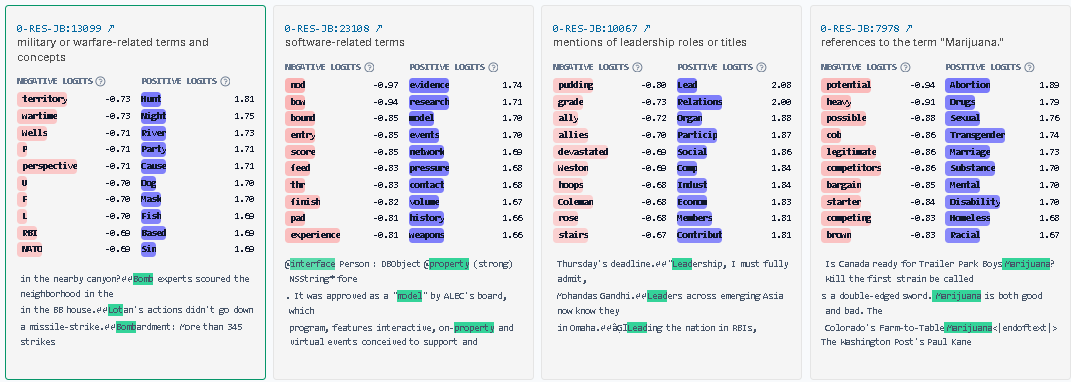

Botton 10 std

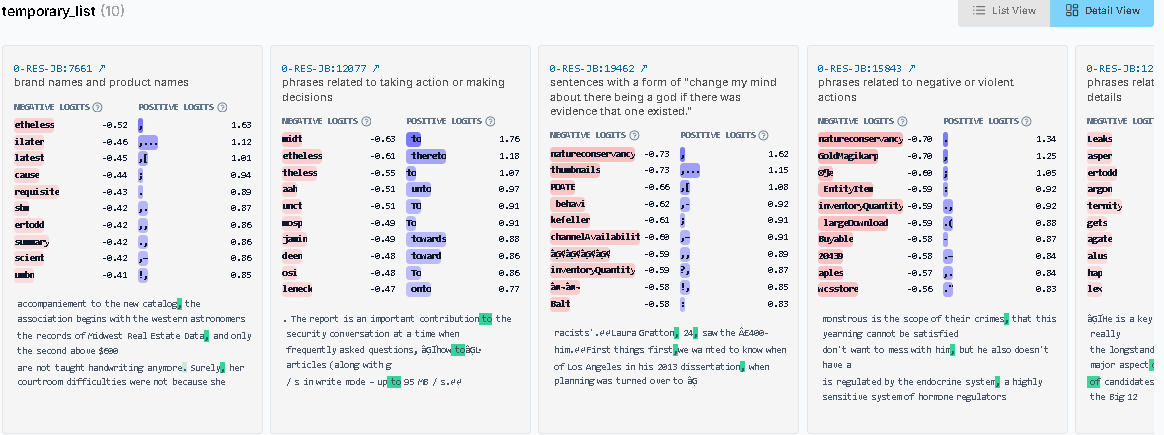

**Analysis by kurtosis**

In [ ]:
tmp_df = W_U_stats_df_dec[["feature", "skewness", "kurtosis", "std"]]
top_10_kt = tmp_df.nlargest(10, "kurtosis")
get_neuronpedia_quick_list(features = list(top_10_kt.feature), sae =gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"] )

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2221461%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%222243%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2223720%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%22419%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2210442%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2210615%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2218710%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2214941%2

In [ ]:
tmp_df = W_U_stats_df_dec[["feature", "skewness", "kurtosis", "std"]]
buttom_10_kt = tmp_df.nsmallest(10, "kurtosis")
get_neuronpedia_quick_list(features = list(buttom_10_kt.feature), sae =gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"] )

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2222348%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%22483%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%223187%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%225796%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2214934%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2210359%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%229472%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%22269%22%7D

Top 10 kurtosis

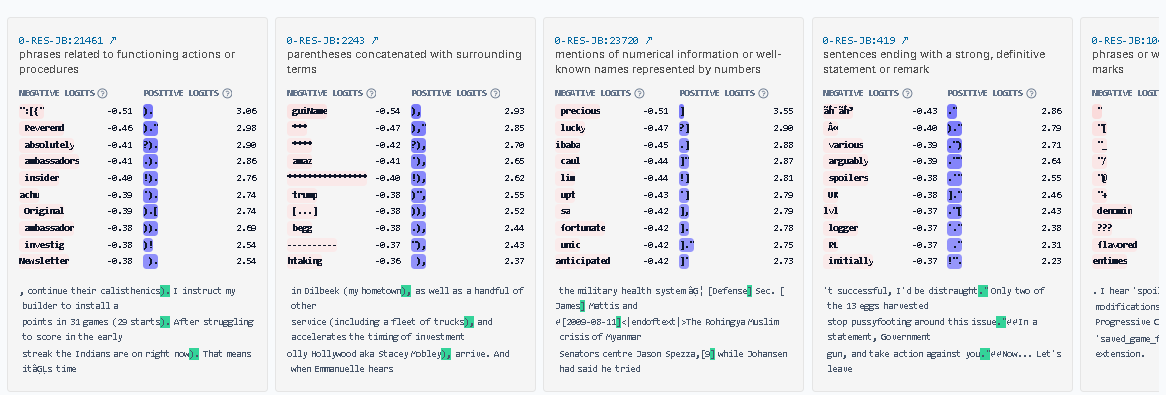

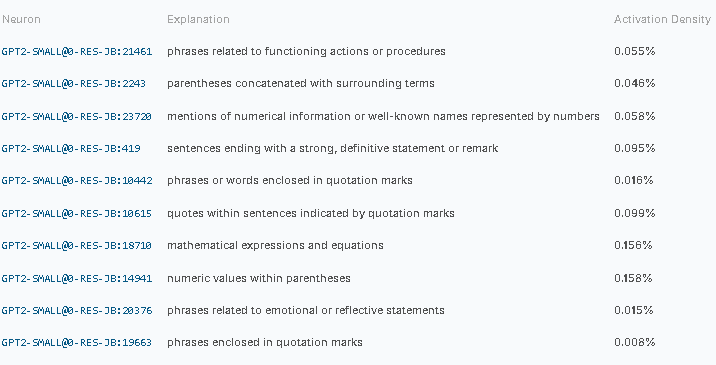

Buttom 10 kurtosis

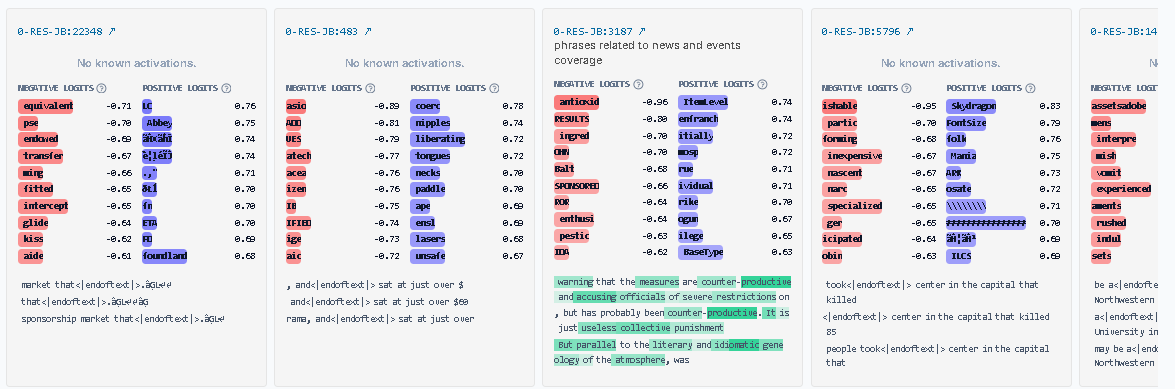

**Analysis by Skewness**

In [ ]:
tmp_df = W_U_stats_df_dec[["feature", "skewness", "kurtosis", "std"]]
top_10_sk = tmp_df.nlargest(10, "kurtosis")
get_neuronpedia_quick_list(features = list(top_10_sk.feature), sae =gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"] )

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2221461%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%222243%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2223720%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%22419%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2210442%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2210615%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2218710%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2214941%2

In [ ]:
tmp_df = W_U_stats_df_dec[["feature", "skewness", "kurtosis", "std"]]
buttom_10_sk = tmp_df.nsmallest(10, "kurtosis")
get_neuronpedia_quick_list(features = list(buttom_10_sk.feature), sae =gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"] )

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2222348%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%22483%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%223187%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%225796%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2214934%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2210359%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%229472%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%22269%22%7D

**Top 10 Skewness**

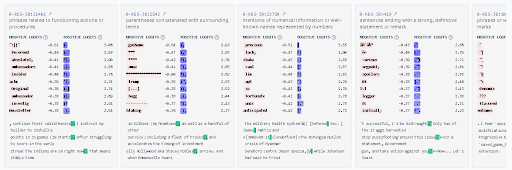

**Buttom 10 Skewness**

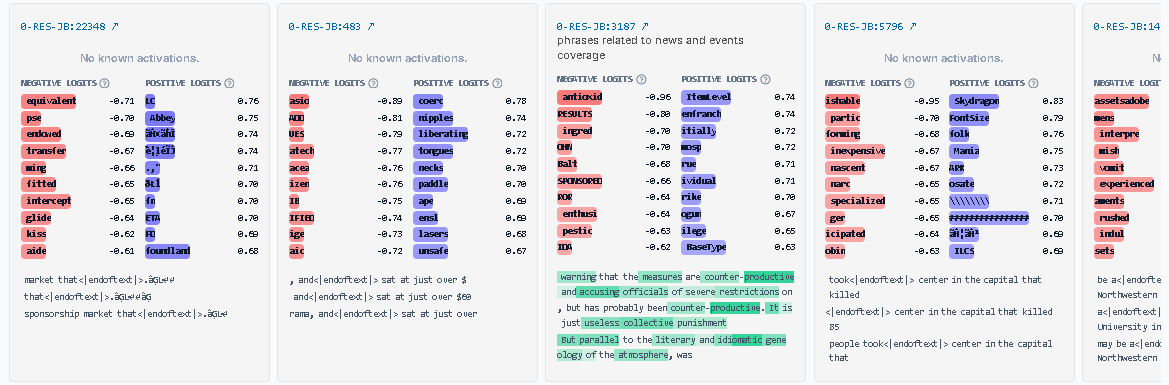

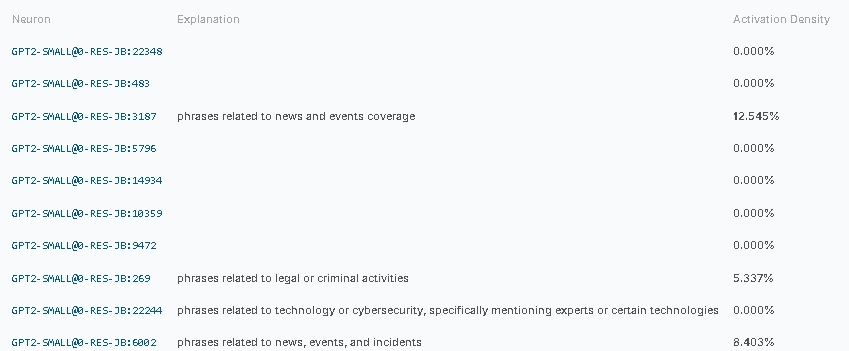


## **Evaluation of Activation Patterns with Medical Prompts**

In [ ]:
#!pip install shap
!pip install sae-lens transformer-lens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.0/920.0 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.8/174.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 114.9 MB/s eta 0:00:00
 

The goal in this subsection is to determine if there are features that are activated when a word associated with a health-related disease appears in the prompt. This exercise is the basis for the document's title. To achieve this, we will once again analyze layer 8 of the previously mentioned model, this time focusing on its activations.

Creating the base prompts

In [ ]:
prompts_health = [
    "Diabetes causes high blood sugar levels.",
    "Asthma leads to breathing difficulties.",
    "Cancer is a leading cause of death.",
    "COVID-19 has caused a global pandemic.",
    "Heart disease is the leading cause of death.",
    "Obesity can lead to various health problems.",
    "Stroke is a medical emergency.",
    "Malaria is spread by mosquitoes.",
    "Flu is caused by the influenza virus.",
    "Hypertension is high blood pressure.",
    "Depression affects mental health.",
    "Tuberculosis is a bacterial infection.",
    "Alzheimer's disease causes memory loss.",
    "HIV leads to AIDS.",
    "Epilepsy causes seizures.",
    "Arthritis causes joint pain.",
    "Migraine is a severe headache.",
    "Osteoporosis weakens bones.",
    "Bronchitis affects the lungs.",
    "Parkinson's disease affects movement.",
    "COPD causes breathing difficulties.",
    "Meningitis can cause inflammation of the brain.",
    "Hepatitis B is a viral liver infection.",
    "Chronic fatigue syndrome causes extreme tiredness.",
    "Multiple sclerosis affects the nervous system.",
    "Leukemia is a cancer of blood-forming tissues.",
    "Gastritis causes inflammation of the stomach lining.",
    "Psoriasis is a skin condition causing red, flaky patches.",
    "Glaucoma damages the optic nerve.",
    "Appendicitis causes inflammation of the appendix.",
    "Cholera is a bacterial disease causing severe diarrhea.",
    "Celiac disease is an immune reaction to gluten.",
    "Eczema causes itchy, inflamed skin.",
    "Gout causes sudden, severe joint pain.",
    "Hemophilia affects the blood's ability to clot.",
    "Hodgkin's lymphoma is a cancer of the lymphatic system.",
    "Irritable bowel syndrome affects the digestive system.",
    "Kidney stones cause severe pain in the abdomen.",
    "Lupus is an autoimmune disease affecting multiple organs.",
    "Melanoma is a serious type of skin cancer.",
    "Mononucleosis is caused by the Epstein-Barr virus.",
    "Pancreatitis causes inflammation of the pancreas.",
    "Pneumonia is an infection of the lungs.",
    "Polio is a viral disease that can cause paralysis.",
    "Prostate cancer affects the prostate gland.",
    "Rabies is a deadly virus spread through animal bites.",
    "Rheumatic fever affects the heart and joints.",
    "Sickle cell anemia affects red blood cells.",
    "Tetanus is caused by bacteria entering through wounds.",
    "Typhoid fever is a bacterial infection.",
    "Ulcerative colitis causes inflammation of the colon.",
    "Varicella is the virus that causes chickenpox.",
    "Whooping cough is a highly contagious respiratory disease.",
    "Zika virus is spread by mosquitoes.",
    "Dengue fever causes severe flu-like symptoms.",
    "Lassa fever is a viral hemorrhagic illness.",
    "Marburg virus causes severe bleeding disorders.",
    "Measles is a highly contagious viral infection.",
    "Mumps causes painful swelling of the salivary glands.",
    "Norovirus is a common cause of gastroenteritis.",
    "Pertussis causes severe coughing spells.",
    "Plague is a serious bacterial infection.",
    "Rift Valley fever is spread by infected mosquitoes.",
    "Rubella causes a red rash and flu-like symptoms.",
    "Scarlet fever causes a red rash and fever.",
    "Syphilis is a sexually transmitted bacterial infection.",
    "Toxoplasmosis is caused by a parasite.",
    "Trichomoniasis is a sexually transmitted infection.",
    "Yellow fever is a viral hemorrhagic disease.",
    "West Nile virus is spread by mosquitoes.",
    "Lyme disease is spread by ticks.",
    "Anthrax is a serious infectious disease caused by bacteria.",
    "Botulism is a rare but serious poisoning caused by toxins.",
    "Chagas disease is caused by a parasite.",
    "Diphtheria is a serious bacterial infection affecting the mucous membranes.",
    "Giardiasis is a parasitic infection of the intestines.",
    "Hantavirus can cause severe respiratory illness.",
    "Legionnaires' disease is a severe form of pneumonia.",
    "Leprosy is a chronic infectious disease caused by bacteria.",
    "Listeriosis is a bacterial infection caused by contaminated food.",
    "Melioidosis is a bacterial infection that can affect any organ.",
    "Onchocerciasis, also known as river blindness, is caused by a parasite.",
    "Psittacosis is an infection transmitted by birds.",
    "Q fever is a bacterial infection.",
    "Rocky Mountain spotted fever is spread by ticks.",
    "Schistosomiasis is caused by parasitic worms.",
    "Smallpox is a contagious viral disease.",
    "Trichinellosis is caused by eating undercooked meat.",
    "Tularemia is a bacterial infection spread by animals.",
    "Yaws is a chronic infection affecting the skin, bones, and joints.",
    "Zoster is the virus that causes shingles.",
    "Alopecia areata causes hair loss.",
    "Dystonia causes involuntary muscle contractions.",
    "Fibromyalgia causes widespread musculoskeletal pain.",
    "Guillain-Barre syndrome is a rare neurological disorder.",
    "Hyperthyroidism causes an overactive thyroid gland.",
    "Hypothyroidism causes an underactive thyroid gland.",
    "Lymphoma is a cancer of the lymph nodes.",
    "Macular degeneration affects vision.",
    "Myasthenia gravis is a neuromuscular disorder.",
    "Narcolepsy causes excessive daytime sleepiness.",
    "Pancreatic cancer affects the pancreas.",
    "Thalassemia is a genetic blood disorder.",
    "Wilson's disease causes copper buildup in the body.",
]


Filter with shap

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import shap
import torch
import pandas as pd


def filter_prompts_by_shap(model, tokenizer, prompts, top_n=3, max_new_tokens=50):
    """
    Filters prompts based on the highest SHAP values associated with pathology names.

    Parameters:
    - model: The GPT-2 model to use for SHAP analysis.
    - tokenizer: The tokenizer corresponding to the model.
    - prompts: A list of medical prompts to analyze.
    - top_n: The number of top SHAP values to consider for each prompt (default is 3).
    - max_new_tokens: Maximum number of new tokens for SHAP generation (default is 50).

    Returns:
    - A list of prompts where the highest SHAP values are associated with the name of a pathology.
    """
    import shap
    import numpy as np

    # Create the SHAP explainer for the model
    explainer = shap.Explainer(model, tokenizer, max_new_tokens=max_new_tokens)

    # Apply SHAP to compute SHAP values for each prompt
    shap_values = explainer(prompts)

    # List to store selected prompts
    selected_prompts = []

    # Iterate over each prompt and its corresponding SHAP values
    for i, prompt in enumerate(prompts):
        # Tokenize the prompt and extract tokens
        tokens = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)["input_ids"].squeeze().tolist()
        token_strings = tokenizer.convert_ids_to_tokens(tokens)

        # Get SHAP values for the current prompt
        shap_values_for_prompt = shap_values[i].values

        # Convert the indices of the highest SHAP values to a list of integers
        max_shap_indices = shap_values_for_prompt.argsort()[-top_n:][::-1].tolist()  # Top n indices of the highest SHAP values

        # Check if any of the tokens with high SHAP values is a pathology
        found = False
        for idx in max_shap_indices:
            # Convert to integer to ensure it's not a list and is in the correct range
            if isinstance(idx, (list, np.ndarray)):  # Check if idx is a list or array
                idx = int(idx[0])  # Convert the first element to an integer
            else:
                idx = int(idx)

            # Ensure the index is within the token range
            if idx < len(token_strings):
                token = token_strings[idx]
                # Check if the token matches any pathology in the prompt
                if any(pathology.lower() in token.lower() for pathology in prompt.split()):
                    found = True
                    break

        if found:
            selected_prompts.append(prompt)

    # Return selected prompts
    return selected_prompts


# Cargar el modelo GPT-2 y el tokenizador
tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
model = AutoModelForCausalLM.from_pretrained("gpt2").cuda()

# Filtrar prompts usando SHAP
selected_prompts = filter_prompts_by_shap(model, tokenizer, prompts_health)

# Mostrar los prompts seleccionados
print("Selected prompts where the highest SHAP value corresponds to the name of the pathology:")
for prompt in selected_prompts:
    print(prompt)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
PartitionExplainer explainer:  27%|██▋       | 28/104 [00:53<03:06,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▍      | 36/104 [01:22<03:50,  3.39s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 41/104 [01:42<03:44,  3.57s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 75/104 [03:24<01:29,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 81/104 [03:52<01:34,  4.11s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 82/104 [03:57<01:39,  4.53s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 90/104 [04:34<00:53,  3.84s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 104/104 [05:25<00:00,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
PartitionExplainer explainer: 105it [05:28,  3.28s/it]


Selected prompts where the highest SHAP value corresponds to the name of the pathology:
Diabetes causes high blood sugar levels.
Asthma leads to breathing difficulties.
Cancer is a leading cause of death.
COVID-19 has caused a global pandemic.
Heart disease is the leading cause of death.
Obesity can lead to various health problems.
Malaria is spread by mosquitoes.
Flu is caused by the influenza virus.
Hypertension is high blood pressure.
Depression affects mental health.
Arthritis causes joint pain.
Bronchitis affects the lungs.
COPD causes breathing difficulties.
Meningitis can cause inflammation of the brain.
Hepatitis B is a viral liver infection.
Chronic fatigue syndrome causes extreme tiredness.
Multiple sclerosis affects the nervous system.
Leukemia is a cancer of blood-forming tissues.
Gastritis causes inflammation of the stomach lining.
Psoriasis is a skin condition causing red, flaky patches.
Appendicitis causes inflammation of the appendix.
Cholera is a bacterial disease caus

In [ ]:
prompts_med = [
    "Diabetes causes high blood sugar levels.",
    "Asthma leads to breathing difficulties.",
    "Cancer is a leading cause of death.",
    "COVID-19 has caused a global pandemic.",
    "Heart disease is the leading cause of death.",
    "Obesity can lead to various health problems.",
    "Malaria is spread by mosquitoes.",
    "Flu is caused by the influenza virus.",
    "Hypertension is high blood pressure.",
    "Depression affects mental health.",
    "Arthritis causes joint pain.",
    "Bronchitis affects the lungs.",
    "COPD causes breathing difficulties.",
    "Meningitis can cause inflammation of the brain.",
    "Hepatitis B is a viral liver infection.",
    "Chronic fatigue syndrome causes extreme tiredness.",
    "Multiple sclerosis affects the nervous system.",
    "Leukemia is a cancer of blood-forming tissues.",
    "Gastritis causes inflammation of the stomach lining.",
    "Psoriasis is a skin condition causing red, flaky patches.",
    "Appendicitis causes inflammation of the appendix.",
    "Cholera is a bacterial disease causing severe diarrhea.",
    "Celiac disease is an immune reaction to gluten.",
    "Hodgkin's lymphoma is a cancer of the lymphatic system.",
    "Irritable bowel syndrome affects the digestive system.",
    "Kidney stones cause severe pain in the abdomen.",
    "Lupus is an autoimmune disease affecting multiple organs.",
    "Melanoma is a serious type of skin cancer.",
    "Mononucleosis is caused by the Epstein-Barr virus.",
    "Pancreatitis causes inflammation of the pancreas.",
    "Pneumonia is an infection of the lungs.",
    "Polio is a viral disease that can cause paralysis.",
    "Prostate cancer affects the prostate gland.",
    "Rabies is a deadly virus spread through animal bites.",
    "Rheumatic fever affects the heart and joints.",
    "Sickle cell anemia affects red blood cells.",
    "Tetanus is caused by bacteria entering through wounds.",
    "Typhoid fever is a bacterial infection.",
    "Ulcerative colitis causes inflammation of the colon.",
    "Varicella is the virus that causes chickenpox.",
    "Zika virus is spread by mosquitoes.",
    "Dengue fever causes severe flu-like symptoms.",
    "Lassa fever is a viral hemorrhagic illness.",
    "Marburg virus causes severe bleeding disorders.",
    "Mumps causes painful swelling of the salivary glands.",
    "Norovirus is a common cause of gastroenteritis.",
    "Pertussis causes severe coughing spells.",
    "Rift Valley fever is spread by infected mosquitoes.",
    "Rubella causes a red rash and flu-like symptoms.",
    "Scarlet fever causes a red rash and fever.",
    "Toxoplasmosis is caused by a parasite.",
    "Trichomoniasis is a sexually transmitted infection.",
    "West Nile virus is spread by mosquitoes.",
    "Lyme disease is spread by ticks.",
    "Anthrax is a serious infectious disease caused by bacteria.",
    "Botulism is a rare but serious poisoning caused by toxins.",
    "Chagas disease is caused by a parasite.",
    "Diphtheria is a serious bacterial infection affecting the mucous membranes.",
    "Giardiasis is a parasitic infection of the intestines.",
    "Hantavirus can cause severe respiratory illness.",
    "Legionnaires' disease is a severe form of pneumonia.",
    "Leprosy is a chronic infectious disease caused by bacteria.",
    "Listeriosis is a bacterial infection caused by contaminated food.",
    "Melioidosis is a bacterial infection that can affect any organ.",
    "Psittacosis is an infection transmitted by birds.",
    "Q fever is a bacterial infection.",
    "Rocky Mountain spotted fever is spread by ticks.",
    "Schistosomiasis is caused by parasitic worms.",
    "Smallpox is a contagious viral disease.",
    "Trichinellosis is caused by eating undercooked meat.",
    "Tularemia is a bacterial infection spread by animals.",
    "Yaws is a chronic infection affecting the skin, bones, and joints.",
    "Zoster is the virus that causes shingles.",
    "Alopecia areata causes hair loss.",
    "Dystonia causes involuntary muscle contractions.",
    "Fibromyalgia causes widespread musculoskeletal pain.",
    "Guillain-Barre syndrome is a rare neurological disorder.",
    "Hyperthyroidism causes an overactive thyroid gland.",
    "Hypothyroidism causes an underactive thyroid gland.",
    "Lymphoma is a cancer of the lymph nodes.",
    "Narcolepsy causes excessive daytime sleepiness.",
    "Pancreatic cancer affects the pancreas.",
    "Thalassemia is a genetic blood disorder.",
    "Wilson's disease causes copper buildup in the body."
]


Selection of influential or pathology-related features

In [ ]:
from sae_lens import SAE
from transformer_lens import HookedTransformer
import torch
import numpy as np
import pandas as pd

In [ ]:
prompts_no_med = [
    "Football is a popular sport worldwide.",
    "Artificial intelligence is transforming industries.",
    "Reading books [fiction, non-fiction] improves vocabulary and imagination.",
    "Quantum computing promises faster calculations.",
    "The Mona Lisa is a famous painting by Leonardo da Vinci (1452-1519).",
    "Climate change is affecting weather patterns globally.",
    "Python is a popular programming language.",
    "Electric cars are becoming more common.",
    "Learning new languages improves cognitive function (memory, attention).",
    "The internet has changed how people communicate; email and social media are key.",
    "Mount Everest is the tallest mountain in the world.",
    "Photography captures moments in time.",
    "Blockchain technology, used in cryptocurrency, is gaining traction.",
    "Music therapy can improve mental well-being.",
    "Gardening is a relaxing and rewarding hobby for all ages.",
    "Mountaineering requires great skill (endurance, strength).",
    "Birdwatching can be a peaceful outdoor activity.",
    "The solar system consists of eight planets.",
    "Philosophy seeks to answer fundamental questions about life.",
    "Painting can be a form of self-expression.",
    "Robotics is advancing rapidly in the tech industry.",
    "Machine learning is a subset of artificial intelligence (AI).",
    "Mars is the fourth planet from the sun.",
    "Cooking is both an art and a science.",
    "Reading fiction can increase empathy.",
    "Classical music helps in concentration.",
    "Globalization connects people across the globe.",
    "Chess is a game of strategy and tactics.",
    "Architecture reflects the culture of its time.",
    "Volunteering helps build a sense of community.",
    "Space exploration (NASA, ESA) expands our understanding of the universe.",
    "Meditation is known for reducing stress and anxiety.",
    "Artificial ecosystems are being studied to restore balance (biodiversity).",
    "Basketball requires agility and teamwork.",
    "Traveling helps broaden one's perspective.",
    "Astronomy involves the study of celestial bodies.",
    "Data science is crucial for making informed decisions.",
    "The Grand Canyon is a natural wonder.",
    "Podcasts are becoming increasingly popular for learning.",
    "Digital art is a new frontier in creative expression.",
    "History provides insights into human behavior and society.",
    "Geology studies the Earth's structure and history.",
    "Renewable energy is key to a sustainable future (solar, wind).",
    "Economics explores how societies manage resources.",
    "Dance is a way to express emotion through movement.",
    "Theater offers a unique experience of live storytelling.",
    "Urban planning shapes the cities of tomorrow.",
    "Cultural heritage is important for national identity.",
    "Writing poetry allows one to express deep emotions.",
    "Music production combines creativity and technology.",
    "Fashion reflects cultural trends and social status.",
    "Photography documents moments in time.",
    "Fiction allows readers to explore alternate realities.",
    "Chess grandmasters possess exceptional strategic skills.",
    "Meteorology helps predict and study weather patterns.",
    "Programming languages evolve with technological needs.",
    "Bioluminescence is a natural phenomenon in some animals.",
    "Mountaineering challenges physical and mental limits.",
    "Mathematics is the language of the universe.",
    "Cycling is both a sport and a mode of transportation.",
    "Public speaking is a valuable skill in many professions.",
    "The study of anthropology explores human cultures.",
    "Learning history helps understand the present.",
    "Marine biology focuses on ocean ecosystems (coral reefs).",
    "Painting is a popular form of visual art.",
    "Classical literature explores timeless human themes.",
    "Astronomy reveals the vastness of space.",
    "Creative writing involves crafting compelling narratives.",
    "Philosophy encourages critical thinking about life's big questions.",
    "Graphic design merges art with communication.",
    "Astronomy helps understand the origins of the universe.",
    "Physics explains the fundamental laws of nature.",
    "Sculpture can be made from many materials (clay, metal).",
    "Hiking promotes physical health and well-being.",
    "The study of linguistics delves into language structures.",
    "Drama explores human relationships through performance.",
    "Virtual reality is reshaping digital experiences.",
    "Music theory helps understand musical compositions.",
    "Ecology studies the interactions between organisms and their environment.",
    "Chess tournaments require intense focus and preparation.",
    "The art of negotiation is crucial in diplomacy.",
    "Traveling exposes one to different cultures and traditions.",
    "Aeronautics explores the science of flight.",
    "Cartography involves the creation of maps.",
    "Ornithology is the study of birds.",
    "Architecture involves both creativity and engineering."
]


In [ ]:
model = HookedTransformer.from_pretrained("gpt2-small")
sae, _, _ = SAE.from_pretrained("gpt2-small-res-jb", "blocks.8.hook_resid_pre", device="cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


blocks.8.hook_resid_pre/cfg.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

In [ ]:
def evaluate_prompts_activation(prompts_med, prompts_no_med, model, sae):
    # Configurar el modelo y SAE en modo de evaluación
    model.eval()
    sae.eval()  # Asegura que el SAE está en modo de evaluación para evitar errores con las máscaras de neuronas

    # Lists to store results

    activation_mean_med = []
    activation_mean_no_med = []

    # Evaluate medical prompts
    for prompt in prompts_med:
        # Evitar el cálculo de gradientes para ahorrar memoria
        with torch.no_grad():
            # Tokenizar el prompt
            tokens = model.to_tokens(prompt)

            # Obtener las activaciones de la capa correspondiente usando el hook del autoencoder
            _, cache = model.run_with_cache(tokens)

            # Usa la función encode del SAE para obtener las activaciones
            feature_activations = sae.encode(cache[sae.cfg.hook_name])
            avegare_per_feature = feature_activations.cpu().mean(dim=(0, 1))


            activation_mean_med.append(avegare_per_feature)
    activa_global_mean_med = torch.stack(activation_mean_med).mean(dim=0)


    for prompt in prompts_no_med:
        # Evitar el cálculo de gradientes para ahorrar memoria
        with torch.no_grad():
            # Tokenizar el prompt
            tokens = model.to_tokens(prompt)

            # Obtener las activaciones de la capa correspondiente usando el hook del autoencoder
            _, cache = model.run_with_cache(tokens)

            # Usa la función encode del SAE para obtener las activaciones
            feature_activations = sae.encode(cache[sae.cfg.hook_name])
            avegare_per_feature = feature_activations.cpu().mean(dim=(0, 1))
            activation_mean_no_med.append(avegare_per_feature)

    activa_global_mean_no_med = torch.stack(activation_mean_no_med).mean(dim=0)

    ind= np.arange(1, len(activa_global_mean_no_med) + 1)

    df = pd.DataFrame({
        'Features_neuron': ind,
        'Activaciones_med': activa_global_mean_med,
        'Activaciones_no_med': activa_global_mean_no_med})

    return df


In [ ]:
df = evaluate_prompts_activation(prompts_med, prompts_no_med, model, sae)

In [ ]:
df_long = pd.melt(df, id_vars=['Features_neuron'], value_vars=['Activaciones_med', 'Activaciones_no_med'],
                  var_name='Tipo', value_name='Activaciones')

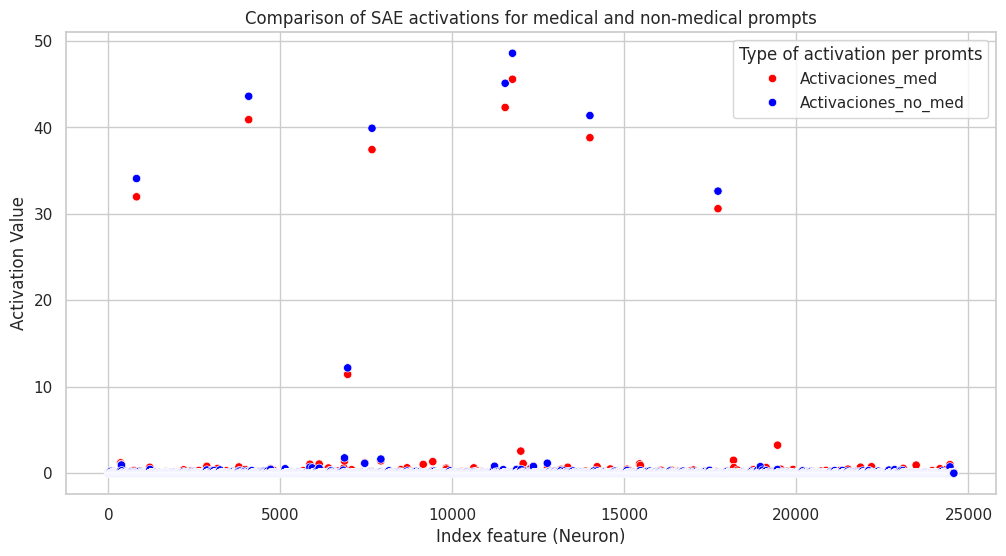

In [ ]:
sns.set(style="whitegrid")

# Crear un gráfico de dispersión
plt.figure(figsize=(12, 6))
scatter_plot = sns.scatterplot(data=df_long, x='Features_neuron', y='Activaciones', hue='Tipo', palette=['red', 'blue'])
plt.title('Comparison of SAE activations for medical and non-medical prompts')
plt.xlabel('Index feature (Neuron)')
plt.ylabel('Activation Value')
plt.legend(title='Type of activation per promts')
plt.show()

In [ ]:
df_med = df[df['Activaciones_med'] > 0]

In [ ]:
df_med['Difference'] = df_med['Activaciones_med'] - df_med['Activaciones_no_med']
df_med = df_med[df_med['Difference'] > 0]


<ipython-input-116-d94c168513f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_med['Difference'] = df_med['Activaciones_med'] - df_med['Activaciones_no_med']


In [ ]:
# Calculate mean and standard deviation
mean = df_med['Difference'].mean()
std_dev = df_med['Difference'].std()

# Define the range for non-outliers (within 2 standard deviations)
lower_bound = mean - 2 * std_dev
upper_bound = mean + 2 * std_dev

# Filter the DataFrame to keep only non-outliers
filtered_df = df_med[(df_med['Difference'] >= lower_bound) & (df_med['Difference'] <= upper_bound)]

# Return the highest values within the filtered range
top_values = filtered_df.nlargest(n=40, columns='Difference') # Modify 'n' as needed


In [ ]:
top_values

,Features_neuron,Activaciones_med,Activaciones_no_med,Difference
10275,10276,0.190654,0.000383,0.190271
739,740,0.313702,0.123839,0.189863
10663,10664,0.187483,0.001924,0.185559
17666,17667,0.185639,0.001511,0.184128
56,57,0.191191,0.008165,0.183026
19716,19717,0.220718,0.041975,0.178743
17470,17471,0.175220,0.000000,0.175220
14623,14624,0.175142,0.000000,0.175142
14287,14288,0.208901,0.034685,0.174216
8825,8826,0.173344,0.000000,0.173344


In [ ]:
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

In [ ]:
gpt2_small_sparse_autoencoders = {}
gpt2_small_sae_sparsities = {}

for layer in range(12):
    sae, original_cfg_dict, sparsity = SAE.from_pretrained(
        release="gpt2-small-res-jb",
        sae_id="blocks.0.hook_resid_pre",
        device="cpu",
    )
    gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"] = sae
    gpt2_small_sae_sparsities[f"blocks.{layer}.hook_resid_pre"] = sparsity

In [ ]:
get_neuronpedia_quick_list(features =top_values['Features_neuron'].tolist() , sae =gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"] )

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2210276%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%22740%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2210664%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2217667%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2257%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2219717%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2217471%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2214624%22%

## **Analysis of Attention Patterns**

## **Application of SHAP for Local Explanations**